# Exploratory Data Analysis for Assesing Pathogenicity Problem

This notebook was created  to showcase EDA for assesing pathogenicity problem. This is just the starting point for farther data analysis, due to allel library dropping some columns and losing us some data. Instead, future versions of EDA should include manually prepared data using pyvcf library.

### Imports and Data Reading

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix

In [24]:
file_path1 = 'D:\pathogenicity_project\pathogenicity-data\EE_015.csv'
file_path2 = 'D:\pathogenicity_project\pathogenicity-data\EE_050.csv'
file_path3 = 'D:\pathogenicity_project\pathogenicity-data\EE_069.csv'
EE_015 = pd.read_csv(file_path1)
EE_050 = pd.read_csv(file_path2)
EE_069 = pd.read_csv(file_path3)

## Data Analysis

For the sake of simplicity in this step we will disregard the "CSQ" column and instead focus on remaining ones.

In [25]:
EE_015.drop(columns="CSQ", inplace=True)
EE_050.drop(columns="CSQ", inplace=True)
EE_069.drop(columns="CSQ", inplace=True)

From now on df is going to be our collective dataframe created by combining data from all other dataframes

In [26]:
df = pd.concat([EE_015, EE_050, EE_069], ignore_index=True)
df

,CHROM,POS,ID,REF,ALT_1,ALT_2,ALT_3,QUAL,FILTER_PASS,FILTER_SB,...,MLEAC_2,MLEAC_3,MLEAF_1,MLEAF_2,MLEAF_3,MQ,MQRankSum,QD,ReadPosRankSum,SOR
0,chr1,15820,rs2691315,G,T,NaN,NaN,NaN,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,chr1,17385,rs201535981,G,A,NaN,NaN,NaN,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,chr1,17697,rs71260069,G,C,NaN,NaN,NaN,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,chr1,133129,rs367730352,G,A,NaN,NaN,NaN,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,chr1,183629,rs71267774,G,A,NaN,NaN,NaN,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
444439,chrY,56856571,rs9988391,G,A,NaN,NaN,293.77,True,False,...,-1.0,-1.0,0.5,NaN,NaN,41.25,-0.431,5.76,-1.020,0.419
444440,chrY,56856581,rs9320083,G,A,NaN,NaN,750.77,True,False,...,-1.0,-1.0,0.5,NaN,NaN,41.23,-2.005,16.68,-0.205,0.361
444441,chrY,56856587,rs7067511,A,C,NaN,NaN,1164.77,True,False,...,-1.0,-1.0,0.5,NaN,NaN,40.19,-3.699,31.48,-1.691,0.530
444442,chrY,56856668,rs5013140,A,G,NaN,NaN,467.77,True,False,...,-1.0,-1.0,0.5,NaN,NaN,44.02,-1.952,33.41,0.183,2.985


The target attribute is ACMG_class. The cardinality of this attribute is 5 with the number of occurences of each example being written below. As can be seen some mutations are much rarer than others, so techniques to fight against problems related to minority class will need to be employed.

C:\Users\mateu\AppData\Local\Temp\ipykernel_13256\2893272337.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='ACMG_class', order=df['ACMG_class'].value_counts().index, palette='coolwarm')


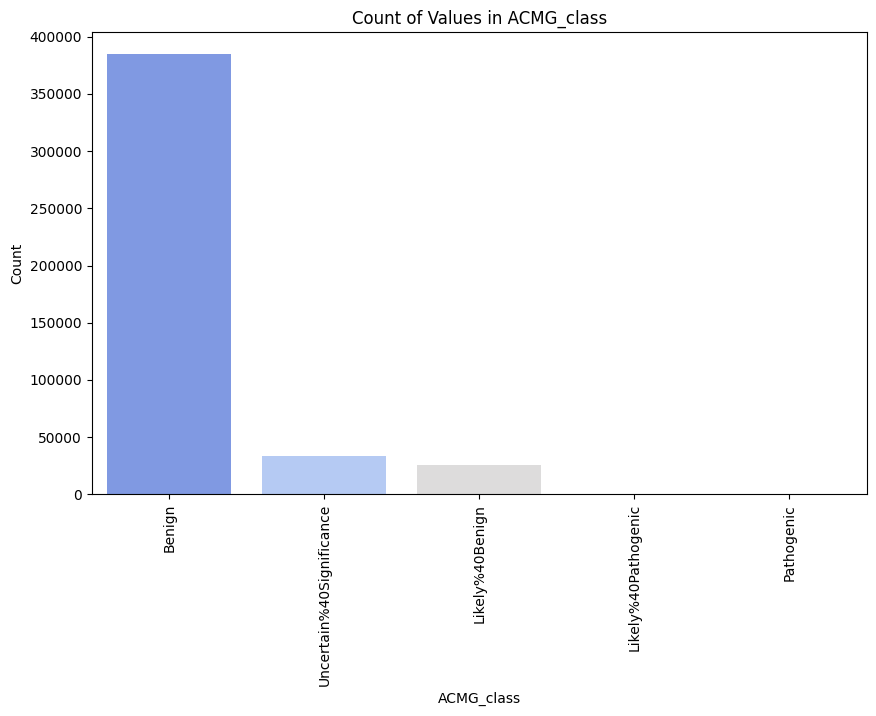

In [27]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='ACMG_class', order=df['ACMG_class'].value_counts().index, palette='coolwarm')
plt.xlabel('ACMG_class')
plt.ylabel('Count')
plt.title('Count of Values in ACMG_class')
plt.xticks(rotation=90)
plt.show()

Below Visualization is meant to provide information about the number of NaNs in chosen columns. Basically, we choose every column that has more than 100 000 Nans, meaning around 1/4th. If such a high numbers of Nans is present, me may consider dropping the column or doing something else with it. As such, We ended up visualizing all attributes for each number of Nans is greater than 100 000 to decide what to do with these columns farther. Some columns are all Nans or close to all Nans, as such dropping this data may be necessary.

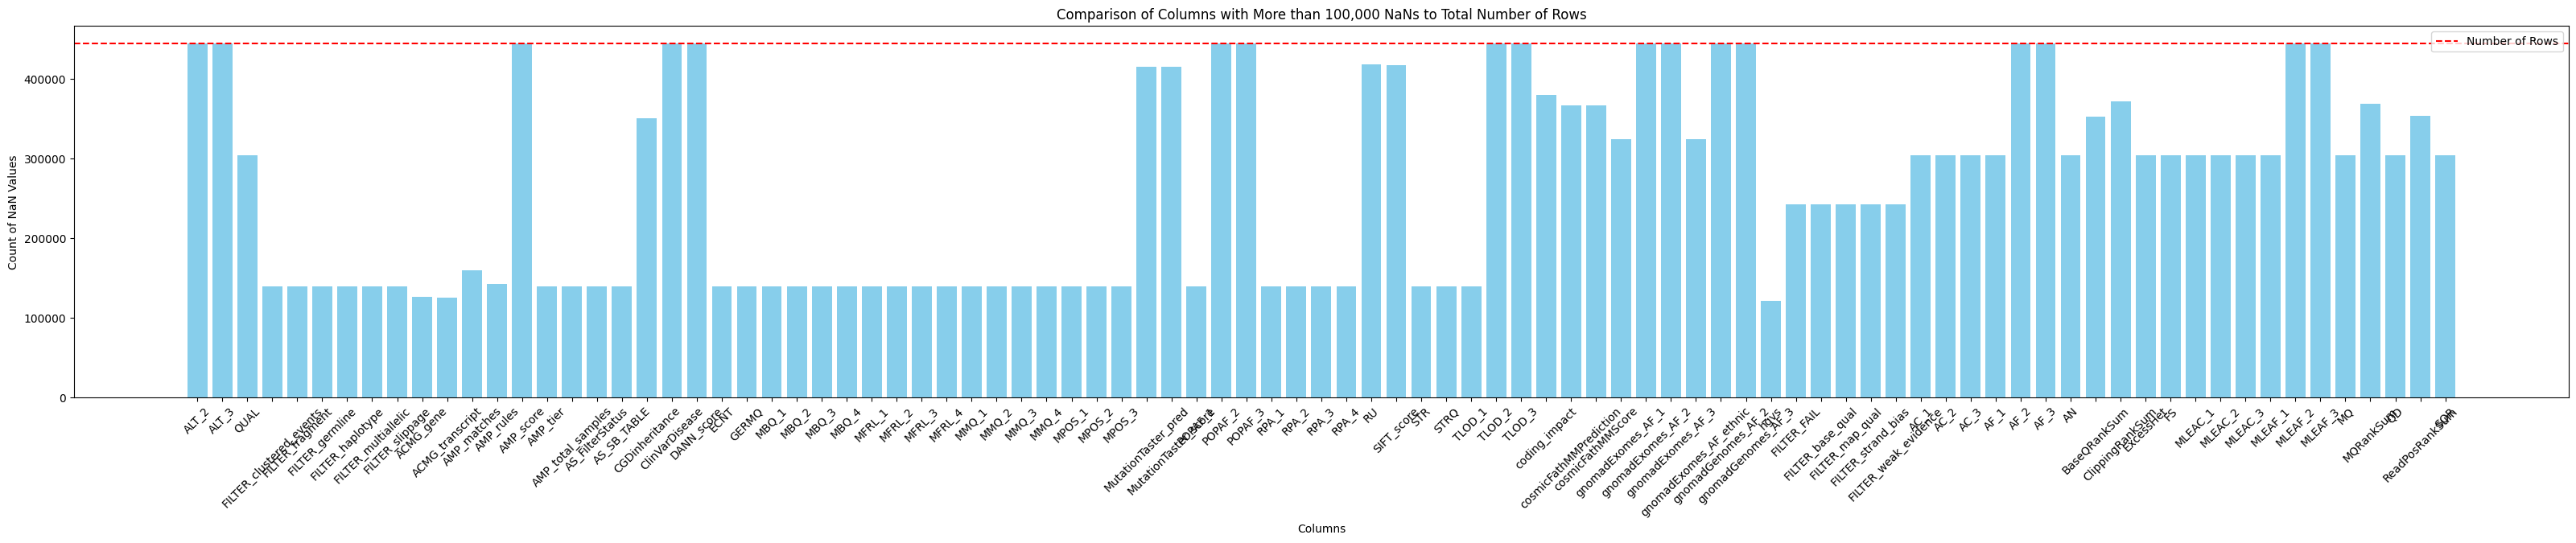

In [28]:
columns_with_nans = []
nan_counts = []
nan_threshold = 100000

for column in df.columns:
    nan_count = df[column].isna().sum()
    if nan_count > nan_threshold:
        columns_with_nans.append(column)
        nan_counts.append(nan_count)

total_rows = len(df)

plt.figure(figsize=(40, 6))
plt.bar(columns_with_nans, nan_counts, color='skyblue')
plt.axhline(y=total_rows, color='r', linestyle='--', label='Number of Rows')
plt.xlabel('Columns')
plt.ylabel('Count of NaN Values')
plt.title('Comparison of Columns with More than 100,000 NaNs to Total Number of Rows')
plt.legend()
plt.xticks(rotation=45)
plt.show()

Dropping all columns with more than 400000 Nans

In [29]:
nan_threshold = 400000

df = df.dropna(axis=1, thresh=len(df) - nan_threshold)

Looking through unique values for "object"(usually string) columns

In [30]:
for column in df.select_dtypes(include=['object']):
    unique_values_count = df[column].nunique()
    print(f"Column '{column}' has {unique_values_count} unique values.")

Column 'CHROM' has 76 unique values.
Column 'ID' has 271138 unique values.
Column 'REF' has 3555 unique values.
Column 'ALT_1' has 2881 unique values.
Column 'FILTER_clustered_events' has 2 unique values.
Column 'FILTER_fragment' has 2 unique values.
Column 'FILTER_germline' has 2 unique values.
Column 'FILTER_haplotype' has 2 unique values.
Column 'FILTER_multiallelic' has 2 unique values.
Column 'FILTER_slippage' has 2 unique values.
Column 'ACMG_class' has 5 unique values.
Column 'ACMG_coding_impact' has 9 unique values.
Column 'ACMG_gene' has 17604 unique values.
Column 'ACMG_rules' has 594 unique values.
Column 'ACMG_transcript' has 20017 unique values.
Column 'AMP_matches' has 4 unique values.
Column 'AMP_rules' has 960 unique values.
Column 'AMP_tier' has 4 unique values.
Column 'AS_FilterStatus' has 63 unique values.
Column 'AS_SB_TABLE' has 86334 unique values.
Column 'CGDinheritance' has 45 unique values.
Column 'Gene' has 26644 unique values.
Column 'STR' has 2 unique values

Visualizing numbers of unique values for every "object" attribute, that way we may know if we should treat them as categorical or not.

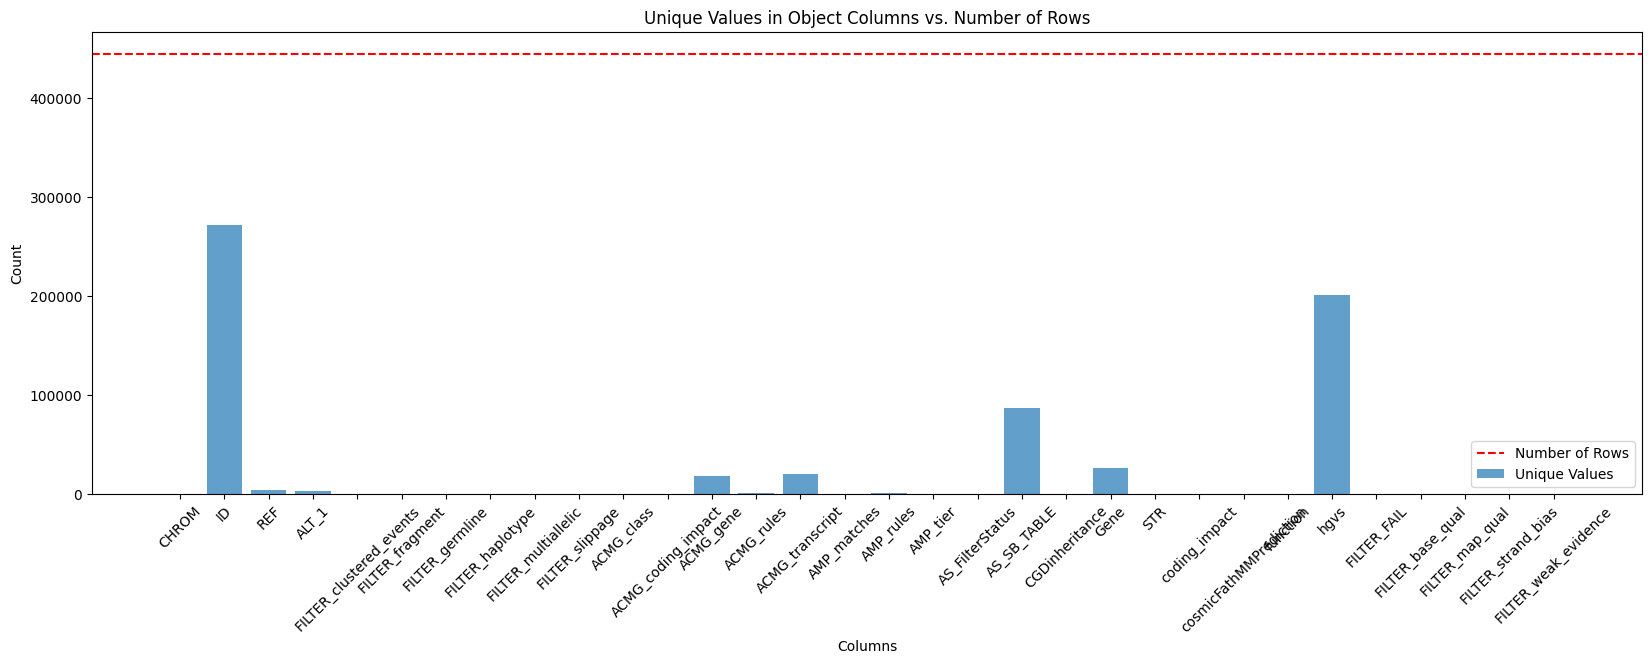

In [31]:
unique_value_counts = []
column_names = []
for column in df.select_dtypes(include=['object']):
    column_names.append(column)
    unique_values_count = df[column].nunique()
    unique_value_counts.append(unique_values_count)

num_rows = len(df)

plt.figure(figsize=(20, 6))
plt.bar(column_names, unique_value_counts, label='Unique Values', alpha=0.7)
plt.axhline(y=num_rows, color='r', linestyle='--', label='Number of Rows')
plt.xlabel('Columns')
plt.ylabel('Count')
plt.title('Unique Values in Object Columns vs. Number of Rows')
plt.legend()
plt.xticks(rotation=45)
plt.show()


Changing every attribute that has less than 10000 unique values to a category.

In [32]:
unique_value_threshold = 10000

for column in df.select_dtypes(include=['object']):
    unique_values_count = df[column].nunique()
    if unique_values_count < unique_value_threshold:
        df[column] = df[column].astype('category')


C:\Users\mateu\AppData\Local\Temp\ipykernel_13256\3916818795.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].astype('category')
C:\Users\mateu\AppData\Local\Temp\ipykernel_13256\3916818795.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].astype('category')
C:\Users\mateu\AppData\Local\Temp\ipykernel_13256\3916818795.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

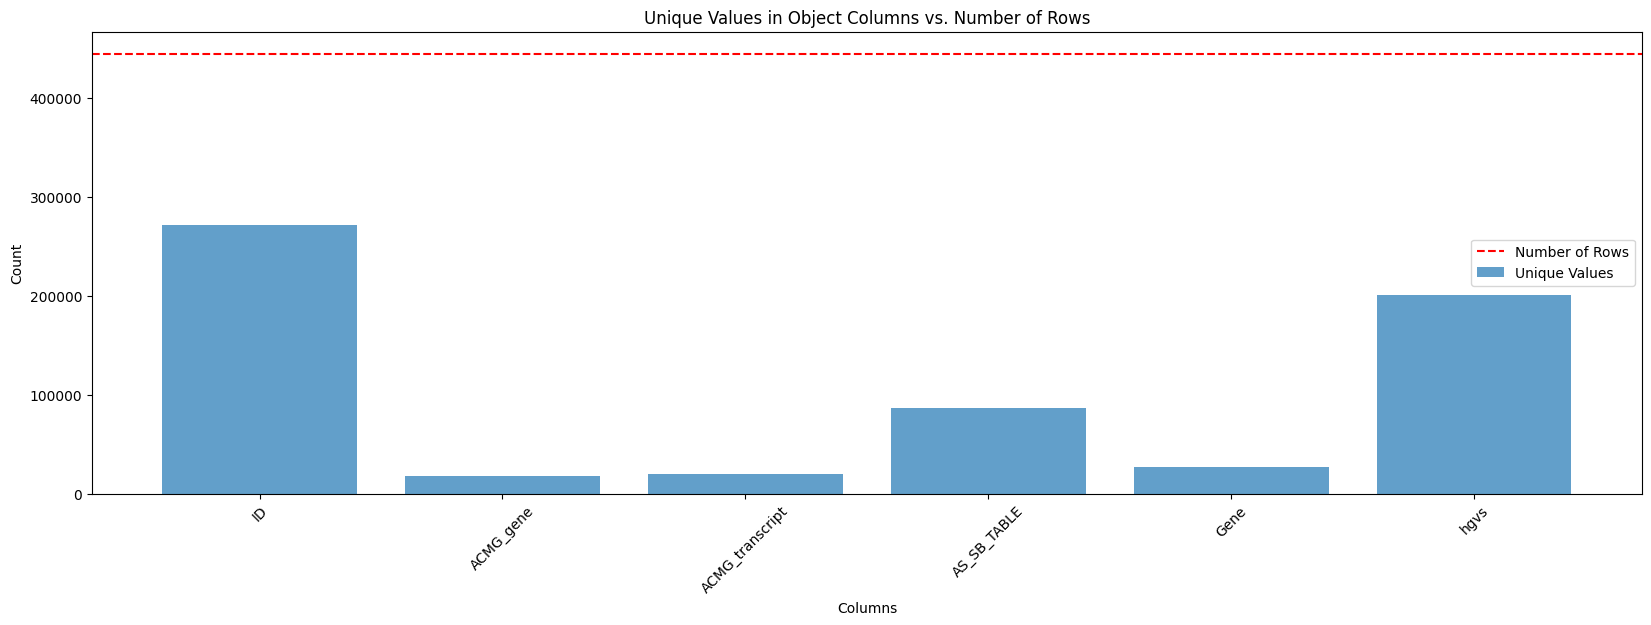

In [33]:
unique_value_counts = []
column_names = []
for column in df.select_dtypes(include=['object']):
    column_names.append(column)
    unique_values_count = df[column].nunique()
    unique_value_counts.append(unique_values_count)

num_rows = len(df)

plt.figure(figsize=(20, 6))
plt.bar(column_names, unique_value_counts, label='Unique Values', alpha=0.7)
plt.axhline(y=num_rows, color='r', linestyle='--', label='Number of Rows')
plt.xlabel('Columns')
plt.ylabel('Count')
plt.title('Unique Values in Object Columns vs. Number of Rows')
plt.legend()
plt.xticks(rotation=45)
plt.show()


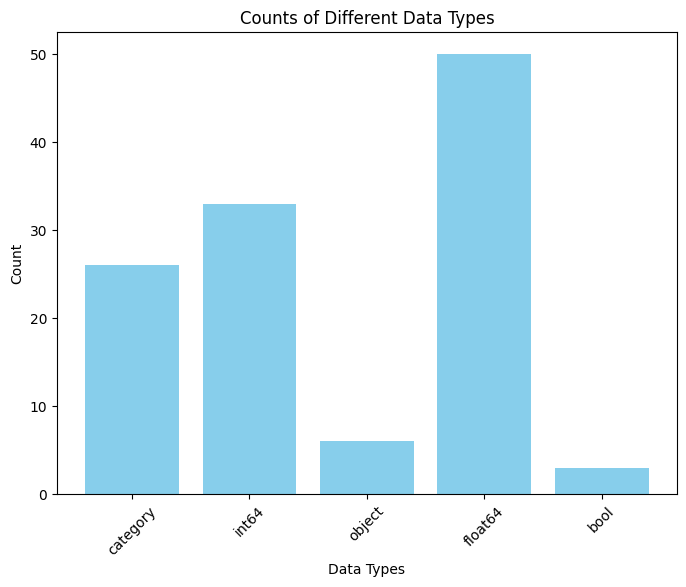

In [34]:
dtype_counts={}
for val in df.dtypes:
    try:
        dtype_counts[str(val)]+=1
    except:
        dtype_counts[str(val)]=1

data_types = list(dtype_counts.keys())
counts = list(dtype_counts.values())

plt.figure(figsize=(8, 6))
plt.bar(data_types, counts, color='skyblue')
plt.xlabel('Data Types')
plt.ylabel('Count')
plt.title('Counts of Different Data Types')
plt.xticks(rotation=45)
plt.show()

Heatmap showing correlation of 15 attributes with highest average correlation.

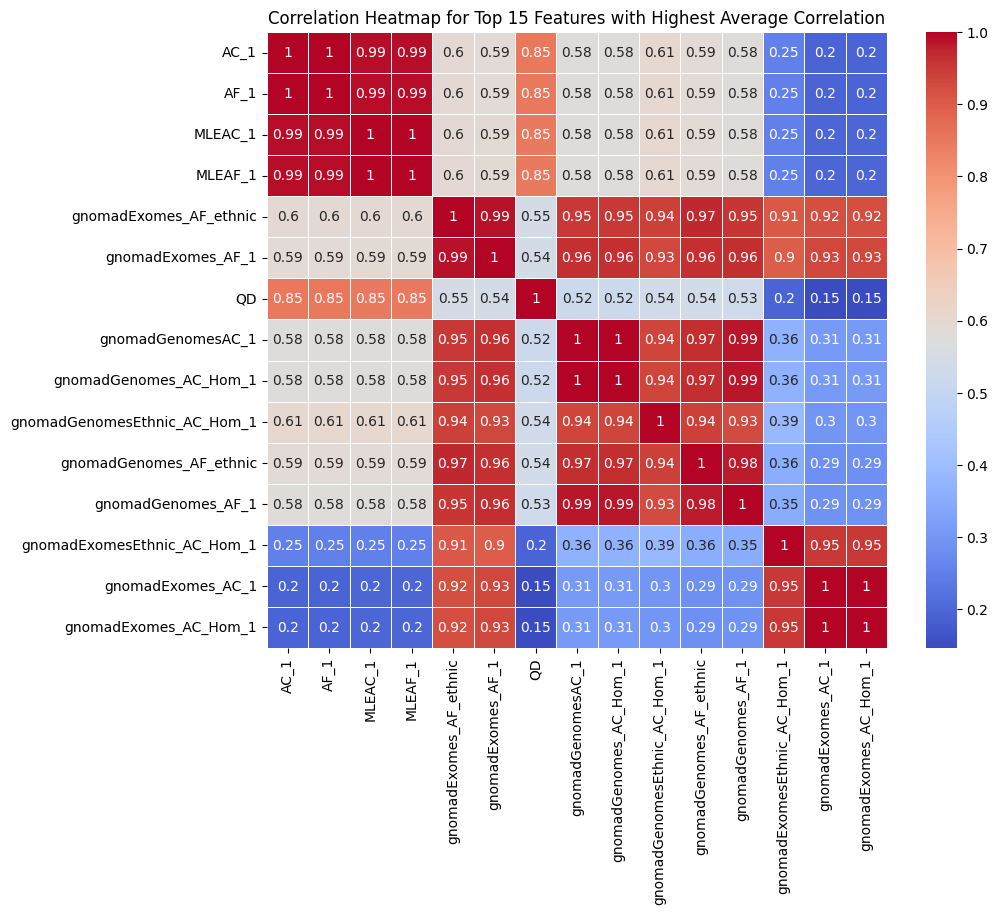

In [35]:
numeric_df = df.select_dtypes(include=['int64', 'float64', 'bool'])


correlation_matrix = numeric_df.corr()
average_correlation = correlation_matrix.abs().mean(axis=1)
top_features = average_correlation.nlargest(15).index

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix.loc[top_features, top_features], annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Heatmap for Top 15 Features with Highest Average Correlation')
plt.show()



In [36]:
unique_value_threshold = 50000

for column in df.columns:
    unique_values_count = df[column].nunique()
    if unique_values_count < unique_value_threshold:
        df[column] = df[column].astype('category')


C:\Users\mateu\AppData\Local\Temp\ipykernel_13256\1963226869.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].astype('category')
C:\Users\mateu\AppData\Local\Temp\ipykernel_13256\1963226869.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].astype('category')
C:\Users\mateu\AppData\Local\Temp\ipykernel_13256\1963226869.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

Below, everything that was an object was changed to category, same for some numerical attributes that had less than 50 000 unique values. This should probably be reviewed and possibly changed in the final implementation.

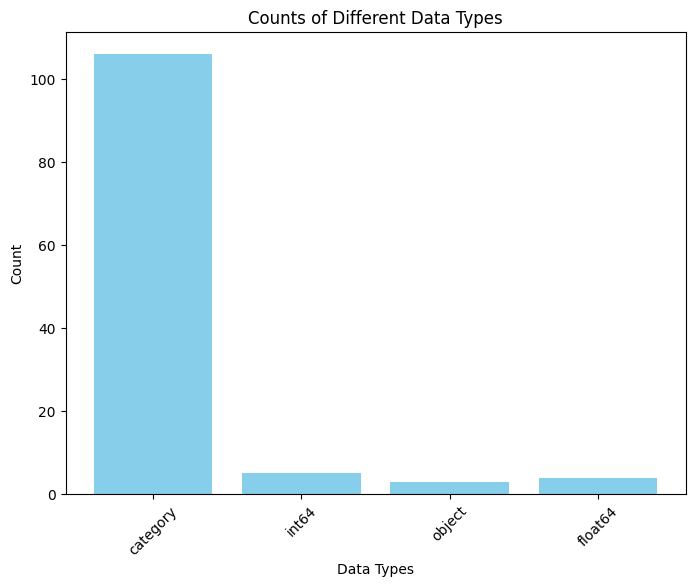

In [37]:
dtype_counts={}
for val in df.dtypes:
    try:
        dtype_counts[str(val)]+=1
    except:
        dtype_counts[str(val)]=1

data_types = list(dtype_counts.keys())
counts = list(dtype_counts.values())

plt.figure(figsize=(8, 6))
plt.bar(data_types, counts, color='skyblue')
plt.xlabel('Data Types')
plt.ylabel('Count')
plt.title('Counts of Different Data Types')
plt.xticks(rotation=45)
plt.show()

Heatmap of correlations for all remaining numerical values.

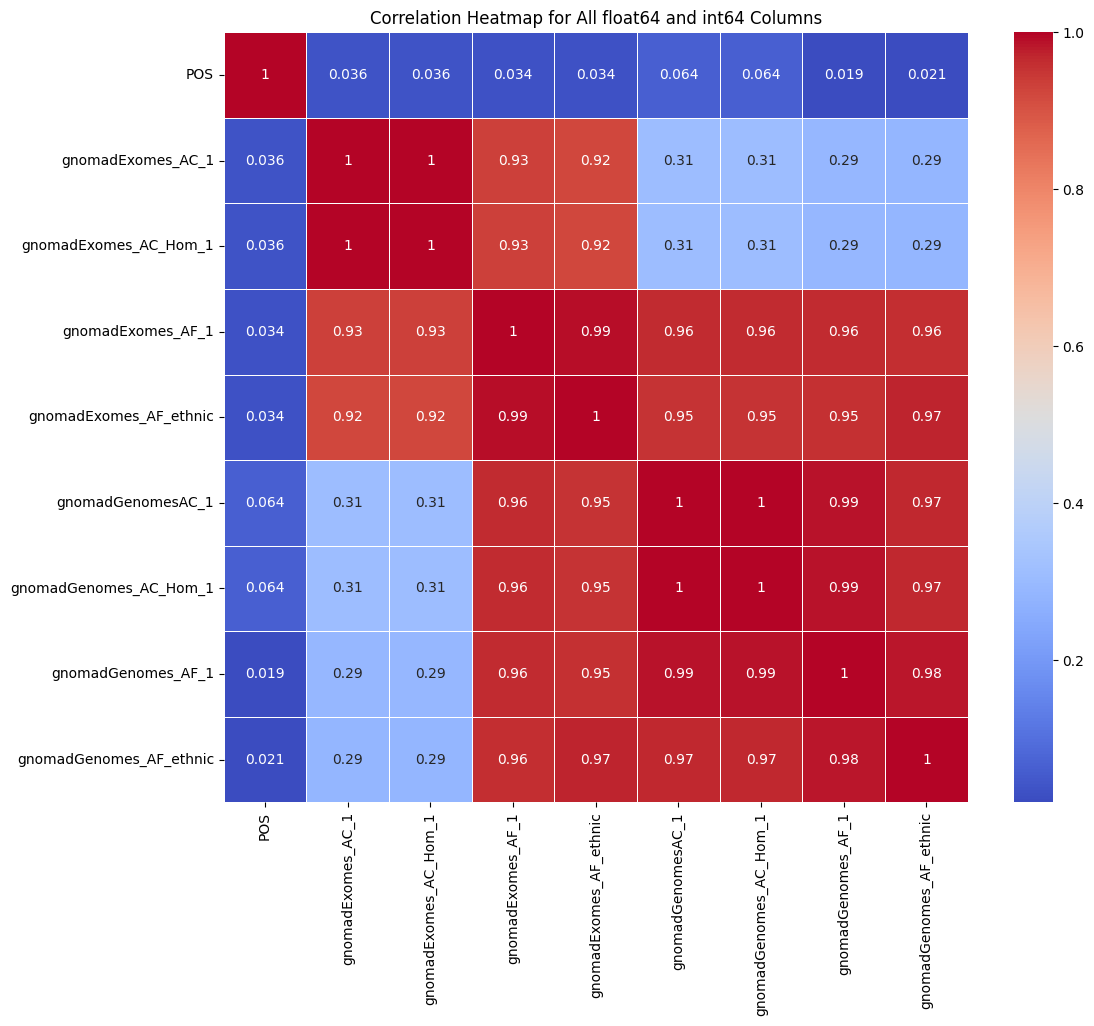

In [38]:
numeric_df = df.select_dtypes(include=['float64', 'int64'])


correlation_matrix = numeric_df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Heatmap for All float64 and int64 Columns')
plt.show()


In [39]:
category_columns = df.select_dtypes(include=['category'])
for column in category_columns:
    category_to_numeric_mapping = {category: index for index, category in enumerate(df[column].cat.categories)}
    df[column] = df[column].cat.codes

object_columns = df.select_dtypes(include=['object'])
for column in object_columns:
    df[column] = df[column].astype('category').cat.codes

C:\Users\mateu\AppData\Local\Temp\ipykernel_13256\2103731316.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].cat.codes
C:\Users\mateu\AppData\Local\Temp\ipykernel_13256\2103731316.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].astype('category').cat.codes
C:\Users\mateu\AppData\Local\Temp\ipykernel_13256\2103731316.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

Showing correlation between 15 most correlated attributes with our target attribute.

C:\Users\mateu\AppData\Local\Temp\ipykernel_13256\1143489307.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlation_with_ACMG_class[top_columns], y=top_columns, orient='h', palette='coolwarm')


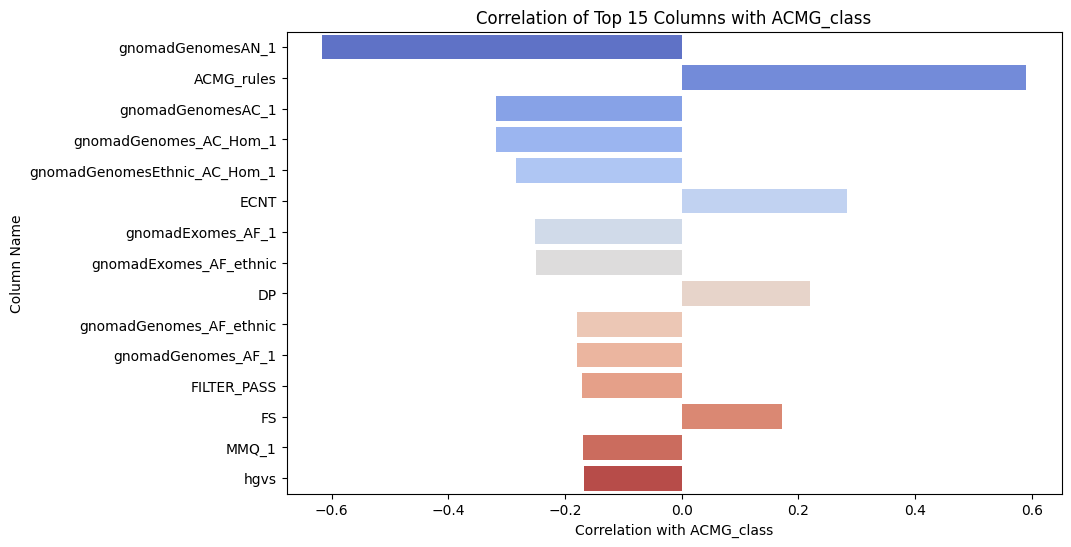

In [40]:
correlation_with_ACMG_class = df.corr()['ACMG_class'].drop('ACMG_class')

top_columns = correlation_with_ACMG_class.abs().nlargest(15).index

plt.figure(figsize=(10, 6))
sns.barplot(x=correlation_with_ACMG_class[top_columns], y=top_columns, orient='h', palette='coolwarm')
plt.xlabel('Correlation with ACMG_class')
plt.ylabel('Column Name')
plt.title('Correlation of Top 15 Columns with ACMG_class')
plt.show()

Showing mutual information between 15 chosen attributes with our target attribute. Nans had to be chnaged to mean for the model to work.

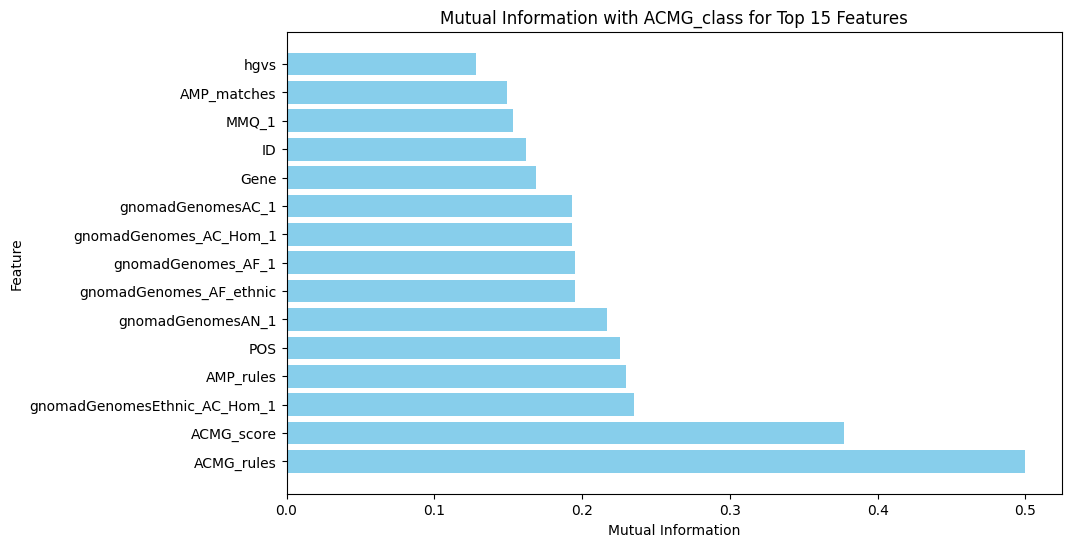

In [41]:
target_column = 'ACMG_class'
df_copy = df.copy()
non_numeric_columns = df_copy.select_dtypes(exclude=['number']).columns
label_encoders = {}

for column in non_numeric_columns:
    label_encoders[column] = LabelEncoder()
    df_copy[column] = label_encoders[column].fit_transform(df_copy[column])

imputer = SimpleImputer(strategy='mean')
X = df_copy.drop(columns=[target_column])
X_imputed = imputer.fit_transform(X)
y = df_copy[target_column]
mutual_info = mutual_info_classif(X_imputed, y)


mutual_info_df = pd.DataFrame({'Feature': X.columns, 'Mutual Information': mutual_info})
mutual_info_df = mutual_info_df.sort_values(by='Mutual Information', ascending=False)
top_features = mutual_info_df.head(15)

plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Mutual Information'], color='skyblue')
plt.xlabel('Mutual Information')
plt.ylabel('Feature')
plt.title('Mutual Information with ACMG_class for Top 15 Features')
plt.show()


Training and reviewing a simple model. Nans were changed to median to allow the model to learn.

In [42]:
imputer = SimpleImputer(strategy='median')
X = df.drop(columns=['ACMG_class'])
X = imputer.fit_transform(X)
y = df['ACMG_class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
clf = RandomForestClassifier(class_weight=dict(enumerate(class_weights)))

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     77156
           1       0.99      0.98      0.99      5141
           2       1.00      0.44      0.62        18
           3       1.00      0.44      0.62         9
           4       0.99      0.99      0.99      6565

    accuracy                           1.00     88889
   macro avg       1.00      0.77      0.84     88889
weighted avg       1.00      1.00      1.00     88889



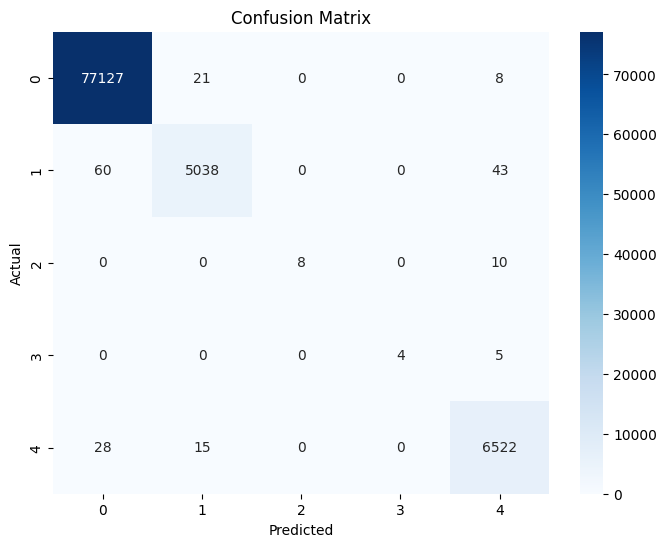

In [45]:
confusion = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
class_names = clf.classes_
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()